In [1]:
import re

import matplotlib.pyplot as plt
import nltk
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn as skl
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from wordcloud import WordCloud
from gensim.models import KeyedVectors
import sys
sys.path.insert(1, "/home/m-joaopr/projetos/nlp/nlp/utils")

from preprocess import *

/home/m-joaopr/projetos/nlp/env/lib/python3.7/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [5]:
df_train = pd.read_csv(
    "/home/m-joaopr/projetos/nlp/nlp/data/tw_pt.csv"
)

In [6]:
df_train.head()

,Unnamed: 0,Text,Classificacao
0,0,���⛪ @ Catedral de Santo Antônio - Governador ...,Neutro
1,1,"� @ Governador Valadares, Minas Gerais https:/...",Neutro
2,2,"�� @ Governador Valadares, Minas Gerais https:...",Neutro
3,3,��� https://t.co/BnDsO34qK0,Neutro
4,4,��� PSOL vai questionar aumento de vereadores ...,Negativo


/home/m-joaopr/projetos/nlp/env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Classificacao', ylabel='count'>

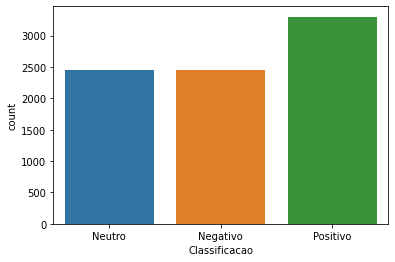

In [8]:
sns.countplot(df_train.Classificacao)

In [5]:
def encoder(df):
    df.replace(to_replace="Positivo",value =1, inplace=True)
    df.replace(to_replace="Negativo",value=-1,inplace=True)
    df.replace(to_replace="Neutro",value=0,inplace=True)

In [6]:
encoder(df_train['Classificacao'])

/home/m-joaopr/projetos/nlp/env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Classificacao', ylabel='count'>

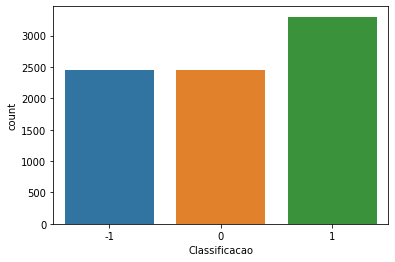

In [7]:
sns.countplot(df_train.Classificacao)

In [8]:
df_train.Classificacao.value_counts()

 1    3300
 0    2453
-1    2446
Name: Classificacao, dtype: int64

In [9]:
lm = WordNetLemmatizer()

In [179]:
corpus = [preprocess(text) for text in df_train.Text.tolist()]

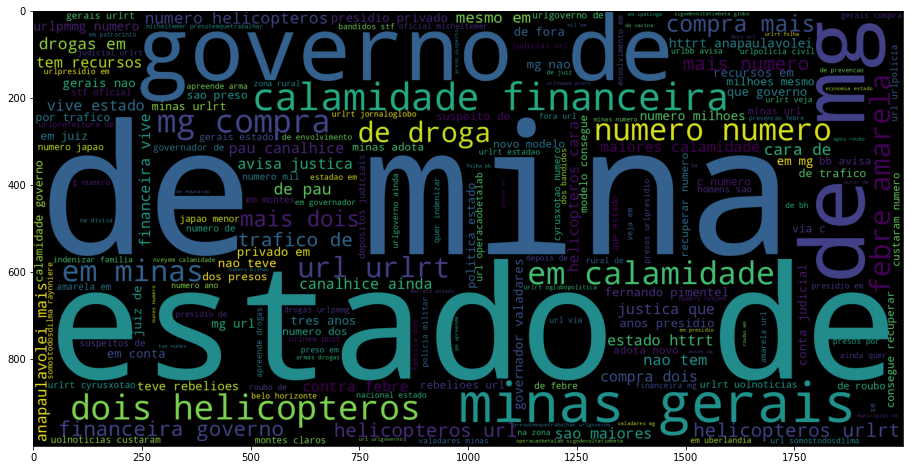

In [180]:
word_cloud = ""
for row in corpus:
    for word in row:
        word_cloud+=" ".join(word)
wordcloud = WordCloud(width=2000,height=1000,background_color ='black',min_font_size = 10).generate(word_cloud)
plt.figure(figsize = (20,8))
plt.imshow(wordcloud)

# Model training

In [12]:
data = "/home/m-joaopr/projetos/nlp/nlp/word2vec/skip_s100.txt"
modelo = KeyedVectors.load_word2vec_format(data)

In [188]:
def word_embedding_generator(text):
    matriz = []

    for word in text.split():
        try:
            vetor = modelo.get_vector(word)
        except KeyError:
            vetor = modelo.get_vector("unknown")
            
        matriz.append(vetor)
            
    phrase = np.asarray(matriz).mean(axis=0)
    return phrase

In [191]:
X = np.asarray([preprocess(text) for text in df_train.Text.tolist()])
target = np.asarray(df_train.Classificacao.tolist())

In [192]:
RANDOM_STATE = 2019

X_train, X_test, Y_train, Y_test = train_test_split(X, target, test_size=0.2,
                                                          random_state=RANDOM_STATE,
                                                          stratify=target)

In [193]:
vectorizer = skl.feature_extraction.text.CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, lowercase = True, binary=False, dtype=np.int32 )
           
x_train = vectorizer.fit_transform(X_train) 
       
x_test = vectorizer.transform(X_test) 
 
tfidf_model = skl.feature_extraction.text.TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)
x_train = tfidf_model.fit_transform(x_train)
x_test = tfidf_model.transform(x_test)

# word embbed

In [183]:
X = np.asanyarray([word_embedding_generator(text) for text in X])

# Tf idf

train, test = train_test_split(X, test_size=0.2)

vectorizer = skl.feature_extraction.text.CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, lowercase = True, binary=False, dtype=np.int32 )
              
x_train = vectorizer.fit_transform(train)       

x_test = vectorizer.transform(test)

tfidf_model = skl.feature_extraction.text.TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)
x_train = tfidf_model.fit_transform(x_train)
x_test = tfidf_model.transform(x_test)

In [184]:
RANDOM_STATE = 2019

X_train, X_test, Y_train, Y_test = train_test_split(X, target, test_size=0.2,
                                                          random_state=RANDOM_STATE,
                                                          stratify=target)

In [194]:
clf = LogisticRegression(random_state=5, max_iter=200).fit(x_train, Y_train)
Y_pred = clf.predict(x_test)

In [195]:
print(classification_report(Y_test, Y_pred, labels=[-1,0,1]))

              precision    recall  f1-score   support

          -1       0.97      0.96      0.96       489
           0       0.93      0.96      0.94       491
           1       0.99      0.98      0.98       660

    accuracy                           0.97      1640
   macro avg       0.96      0.96      0.96      1640
weighted avg       0.97      0.97      0.97      1640



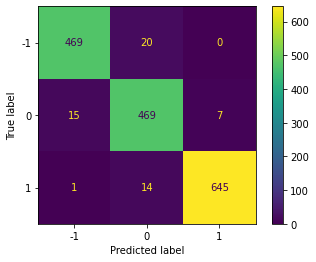

In [196]:
plot_confusion_matrix(clf, x_test, Y_test)
plt.show()

# salvando e carregando o modelo

In [135]:
import pickle
filename = '/home/m-joaopr/projetos/nlp/nlp/saved_model/wordemb.sav'
pickle.dump(clf, open(filename, 'wb'))

In [173]:
import pickle
filename = '/home/m-joaopr/projetos/nlp/nlp/saved_model/tfidf.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x_test, Y_test)
print(result)

0.9652439024390244


# Test Model

In [136]:
df = pd.read_csv(
    "/home/m-joaopr/projetos/nlp/nlp/data/b2w.csv",
    usecols=["review_text","polarity","rating"]
)

In [137]:
df.head()

,review_text,polarity,rating
0,Bem macio e felpudo...recomendo. Preço imbatí...,1.0,4
1,Produto excepcional! recomendo!!! inovador e ...,1.0,5
2,recebi o produto antes do prazo mas veio com d...,0.0,1
3,Bom custo beneficio. Adequado para pessoas que...,1.0,5
4,Além de higiênico tem o tamanho ideal. Só falt...,NaN,3


In [138]:
df.dropna(inplace=True)
pos_b2w = df.query('rating==5')[0:500]
neg_b2w = df.query('rating<=1')[0:500]
new_b2w = pd.concat([neg_b2w,pos_b2w])
new_b2w.polarity.replace([0],[-1], inplace=True)

In [139]:
X_ = np.asarray([preprocess(text) for text in new_b2w.review_text.tolist()])
X_ = np.asarray([word_embedding_generator(text) for text in X_])
y = np.asarray(new_b2w.polarity.tolist())

In [156]:
#x = vectorizer.transform(X_)
#x = tfidf_model.transform(x)

In [141]:
Y_pred = loaded_model.predict(X_)

In [142]:
print(classification_report(y, Y_pred, labels=[-1,1]))

              precision    recall  f1-score   support

          -1       0.49      0.50      0.50       500
           1       0.80      0.18      0.29       500

   micro avg       0.54      0.34      0.42      1000
   macro avg       0.65      0.34      0.40      1000
weighted avg       0.65      0.34      0.40      1000



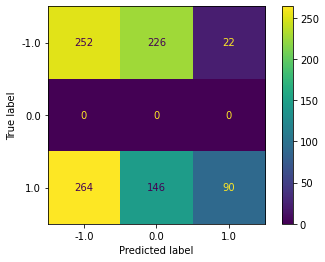

In [126]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X_, y)
plt.show()

In [147]:
poze_ = ["Celular nao veio na cor escolhida"]

In [174]:
frases = np.asarray(['Mochila maravilhosa, linda de boa qualidade. Muito satisfeita, obrigada',
          'Produto de qualidade com um precinho camarada já comprei mais de uma vez e pretendo comprar novamente',
          'Boa noite ele atende as minhas expectativas só que ele deveria ter mais potencia',
          'Embora pequeno, tem uma boa ventilação e é relativamente silencioso. Muito bom produto, recomendo',
          'Bom gostei muito, achei que pelo preço e ótimo',
          'Produto de baixíssima qualidade. Parece "resto" de produção. Já tive outros da mesma marca, que comprei diretamente na china, mas este foi o pior que já comprei.',
          'Muito ruim, lado esquerdo não funciona. Volume do lado direito muito baixo, não gostei. Joguei meu dinheiro fora.',
          'Produto usado, com lista de contatos e tudo. Que absurdo, vender um produto que custou quase 2 mil reais usado. Falta de respeito com o cliente. Nem se preocuparam em apagar os registros de uso.',
          'Arrependimento total, o celular não tira foto pela câmera do whats o sensor é ruim, só vim vê o negócio da câmera agora, se não já tinha devolvido o celular.',
          'Bateria não dura nem meio dia trava e apaga do nada produto pirateado nunca que é primeira linha paguei caro e não tenho telefone confiável.'])

X = np.asarray([preprocess(text) for text in frases])
#X = np.asarray([word_embedding_generator(text) for text in X])
target = np.asarray([1,1,1,1,1,-1,-1,-1,-1,-1])

In [175]:
x = vectorizer.transform(X)
x = tfidf_model.transform(x)

In [176]:
Y_pred = loaded_model.predict(x)

In [177]:
Y_pred

array([ 1,  0, -1,  0,  0,  0,  1, -1,  0,  0])

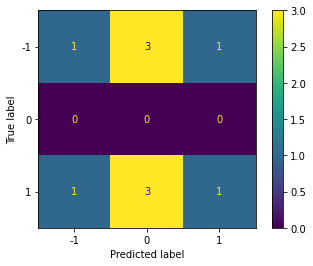

In [178]:
plot_confusion_matrix(loaded_model, x, target)
plt.show()